In [55]:
##Imports
%matplotlib inline

from PIL import Image, ImageEnhance
import PIL.ImageOps
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from pathlib import Path
import json
import pickle
import os.path
import stat
from shutil import copyfile
from object_detection.utils import dataset_util
from os import listdir
from os.path import isfile, join, isdir
import tensorflow as tf
from tensorflow import io
import io as IO
import logging
import tensorflow.compat.v1 as tfv1

In [9]:
"""
parseJSON(): extracts masks from LabelBox export JSON and organizes them into a folder 

"""
def parseJSON(file,mainDir = "Dataset/Test Folder/"):
    
    
    with open(file) as json_file:
        dataDict = json.load(json_file)
    for i in range(0,10):
        imageFileName = dataDict[i]["External ID"]
        newPath = mainDir + imageFileName[:-4]
        #Make directories for files if not exist
        Path(newPath).mkdir(parents=False, exist_ok=True)
        maskPath = newPath+"/Masks"
        Path(maskPath).mkdir(parents=False,exist_ok=True)
        instanceList = dataDict[i]["Label"]["objects"]
        instanceValList = []
        ogPicPath = "Dataset/Only Pictures Dataset/"+imageFileName
        
        #Copy image file from pic only dataset to the image folder
        if(os.path.isfile(ogPicPath) and not(os.path.isfile(newPath + "/" +imageFileName))):
            os.chmod(newPath,stat.S_IWUSR)
            copyfile(ogPicPath, newPath+ "/" +imageFileName)
        for j in range(0,len(instanceList)):
            #Get instance type
            value = instanceList[j]["value"]
            instanceValList.append(value)
            #Get and save image to file
            currentMaskPath = maskPath + "/" + str(j) + "_"+ value  + ".png"
            if(not (os.path.isfile(currentMaskPath))):
                #Write image to file
                instanceURI = instanceList[j]["instanceURI"]
                response = requests.get(instanceURI)
                rgbImage = Image.open(BytesIO(response.content))
                maskImage = rgbImage.convert(mode = "1",dither = None)
                maskImage.save(currentMaskPath)
                    
        propertiesDict = {}
        propertiesDict["ImageFileName"] = imageFileName
        propertiesDict["instanceValList"] = instanceValList
        propertiesDict["ImageSize"] = Image.open(newPath+ "/" +imageFileName).size
        with open(newPath + "/properties.json", 'w') as outfile:
            json.dump(propertiesDict, outfile)

            
            
        
            
    return dataDict
    
    
data = parseJSON("Dataset/Exports/export-2020-06-16T23_45_26.499Z.json")
#read picked text
# with open("Dataset/Test Folder/98_1_1/values.txt", "rb") as fp:   # Unpickling
#     b = pickle.load(fp)
    
# b

(1080, 1920)


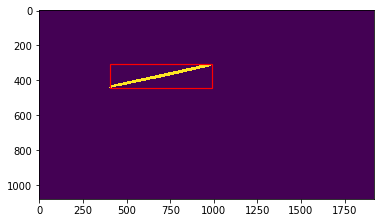

In [10]:
#Used for mask testing probs
with io.gfile.GFile("Dataset/Test Folder/10_2_1/Masks/0_wire.png", 'rb') as fid:
    encoded_mask_png = fid.read()
    encoded_mask_io = IO.BytesIO(encoded_mask_png)
    mask = np.asarray(PIL.Image.open(encoded_mask_io))
    print(mask.shape)
    rows,columns = np.where(mask != 0)
    fig,ax = plt.subplots(1)
    maxRow = np.amax(rows)
    minRow = np.amin(rows)
    maxCol = np.amax(columns)
    minCol = np.amin(columns)
    rect = Rectangle((minCol, minRow), maxCol - minCol, maxRow - minRow,fill=False, color='r', alpha=1,lw = 1.2) 
    ax.imshow(mask)
    ax.add_patch(rect)
    plt.show()

    

In [11]:
dic = {}
dic["wire"] = 1
dic["breadboard"] = 2
dic["void"] = 3

lis = ["wire","wire","wire","wire","wire","breadboard","void"]
[dic[x] for x in lis]

[1, 1, 1, 1, 1, 2, 3]

In [45]:
def createExample(image_subdir,label_to_int_dict):
    #Get image properties and mask information
    with open(image_subdir + "/properties.json") as json_file:
        properties = json.load(json_file)
    imageFileName = properties["ImageFileName"]
    instanceValList = properties["instanceValList"]
    imageSize = properties["ImageSize"]
    
    #get size
    width = imageSize[0]
    height = imageSize[1]

    img_path = image_subdir + "/" + imageFileName
    
    #encode image png
    with io.gfile.GFile(img_path, 'rb') as fid:
        encoded_image = fid.read()
                
    #Process Masks#
    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    encoded_mask_png_list = []
    mask_subdir = image_subdir + "/Masks"
    maskFiles = [join(mask_subdir, f) for f in listdir(mask_subdir) if isfile(join(mask_subdir, f))]
    for file in maskFiles:
        #encode mask pngs
        with io.gfile.GFile(file, 'rb') as fid:
            encoded_mask_png = fid.read()
            encoded_mask_png_list.append(encoded_mask_png)
            encoded_mask_io = IO.BytesIO(encoded_mask_png)
            mask = np.asarray(PIL.Image.open(encoded_mask_io))
            rows,columns = np.where(mask != 0)
            ymax = float(np.amax(rows))
            ymin = float(np.amin(rows))
            xmax = float(np.amax(columns))
            xmin = float(np.amin(columns))
            xmins.append(xmin / width)
            ymins.append(ymin / height)
            xmaxs.append(xmax / width)
            ymaxs.append(ymax / height)
            

    #Set classes text
    classes_text = [x.encode("utf8") for x in instanceValList]
    #Set class mapping
    classes = [label_to_int_dict[x] for x in instanceValList]
    
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height), #check
      'image/width': dataset_util.int64_feature(width), #check
      'image/filename': dataset_util.bytes_feature(imageFileName.encode("utf8")), #check
      'image/source_id': dataset_util.bytes_feature(imageFileName.encode("utf8")), #check
      'image/encoded': dataset_util.bytes_feature(encoded_image), #check
      'image/format': dataset_util.bytes_feature("png".encode("utf8")), #check
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins), #check
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs), #check
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins), #check
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs), #check 
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text), #check
      'image/object/class/label': dataset_util.int64_list_feature(classes), #check
      'image/object/mask': dataset_util.bytes_list_feature(encoded_mask_png_list), #check
      }))
    
    
    return tf_example

b'10_2_1.png'
1080
[0.28333333134651184, 0.4287036955356598, 0.25462964177131653, 0.43796294927597046, 0.5592592358589172, 0.6101852059364319, 0.20555555820465088, 0.0]
[b'wire', b'wire', b'wire', b'wire', b'wire', b'wire', b'breadboard', b'void']
b'10_2_2.png'
1080
[0.4277777671813965, 0.28333333134651184, 0.1953703761100769, 0.0, 0.6074073910713196, 0.5574073791503906, 0.43611112236976624, 0.25648146867752075]
[b'wire', b'wire', b'breadboard', b'void', b'wire', b'wire', b'wire', b'wire']


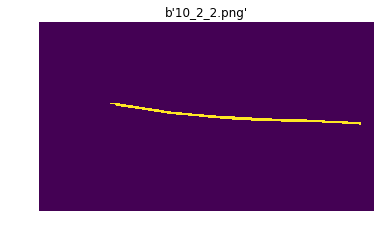

In [52]:
def writeTFRecord(outputFile,main_dir):
    label_to_int_dict = {}
    label_to_int_dict["wire"] = 1
    label_to_int_dict["breadboard"] = 2
    label_to_int_dict["void"] = 3
    
    dataDirectories = [join(main_dir, d) for d in listdir(main_dir) if isdir(join(main_dir, d))]
    writer = io.TFRecordWriter(outputFile)

    for image_subdir in dataDirectories[0:2]:
        try:
            example = createExample(image_subdir,label_to_int_dict)
            writer.write(example.SerializeToString())
        except ValueError:
            logging.warning('Invalid example: %s, ignoring.', image_subdir)

    writer.close()
        
def readTFRecord(tf_file):
    filenames = ['tf_record_test.tfrecords']
    raw_dataset = tf.data.TFRecordDataset(filenames)

    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        feature = example.features.feature
        #reads image and puts it in tensor
        raw_img = feature['image/encoded'].bytes_list.value[0]
        img = tf.image.decode_png(raw_img)
        #reads mask and puts it in nupy array
        raw_img = feature['image/object/mask'].bytes_list.value[0]
        img = tf.image.decode_png(raw_img)
        mask_img = img.numpy().squeeze()
        plt.imshow(mask_img)
        plt.axis('off')
        _ = plt.title(feature["image/filename"].bytes_list.value[0])
        
        #reads image filename
        fileName = feature['image/filename'].bytes_list.value[0]
        print(fileName)
        #reads height (int64)
        height = feature['image/height'].int64_list.value[0]
        print(height)
        #reads ymin list (float)
        ymins = feature['image/object/bbox/ymin'].float_list.value
        print(ymins)
        #reads instance list
        instanceList = feature['image/object/class/text'].bytes_list.value
        print(instanceList)
        

    
writeTFRecord('tf_record_test.tfrecords',"Dataset/Test Folder")
readTFRecord('tf_record_test.tfrecords')


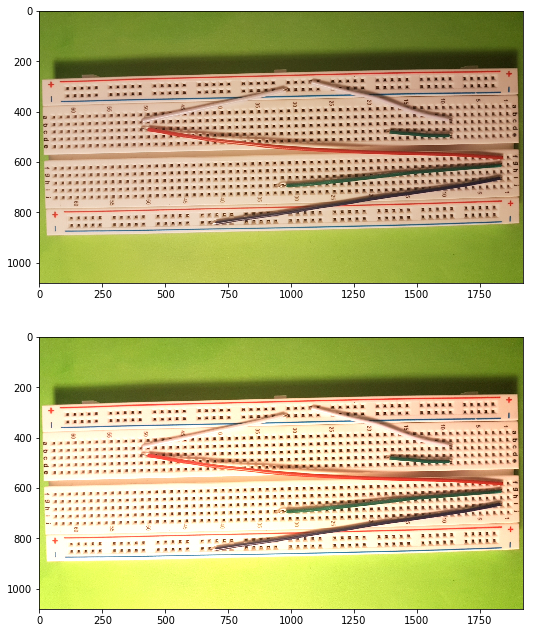

In [73]:
def changeBrightness(img):
    enhancer = ImageEnhance.Brightness(img)
    factor = 1.3
    #min factor is 0.6
    #max factor is 1.3
    im_output = enhancer.enhance(factor)
    return im_output

fig,ax = plt.subplots(2)
img = Image.open("Dataset/Test Folder/10_2_1/10_2_1.png")
out = changeBrightness(img)
ax[0].imshow(img)
ax[1].imshow(out)
fig.set_size_inches((12,11))
plt.show()